In [1]:
import cv2,os,torch
import json
import matplotlib.pyplot as plt
import numpy as np
from load_data import load_data
from torch.utils.data import Dataset,DataLoader
import albumentations as albu
import torchvision
import torch.nn as nn
import sys
sys.path.append('/home/chenyixin/chenyixin/')
import segmentor

Backbone HRNet Pretrained weights at: ./checkpoints/hrnetv2_32_model_best_epoch96.pth, only usable for HRNetv2-32


In [2]:
def load_data(path='./data',mode='train',verbose=False):
    types_dict = {'上皮':0, '生殖':1, '性索间质':2,'炎症':3,'巧囊':4,'性索':2}
    imgs,masks_pa,masks_tu,type_labels = [],[],[],[]
    name = []
    
    for basepath,dirnames,files in os.walk(path):
        jpg = [f for f in files if '.jpg' in f]
        if len(jpg) == 0:
            continue
        for j in jpg:
            jpg_path = os.path.join(basepath,j)
            img = cv2.imread(jpg_path)

            try:
                js = json.load(open(jpg_path.replace('.jpg','.json'),'r'))
            except:
                print(jpg_path)
                break
            if len(img.shape)==2:    
                mask = np.zeros_like(img)
            elif len(img.shape) ==3:
                mask_pa = np.zeros_like(img[:,:,0])
                mask_tu = np.zeros_like(img[:,:,0])
            for shape in js['shapes']:
                if shape['label']== "papillary":
                    cv2.fillPoly(mask_pa,[np.int32(shape['points'])],color=255)
                if shape['label']== "tumor":
                    cv2.fillPoly(mask_tu,[np.int32(shape['points'])],color=255)
            flag = False
            for t in types_dict:
                if t in basepath:
                    flag = True
                    break
            if not flag:
                print(t)
            na = basepath.replace("/Image","").split("/")[-1]
            
            if np.max(mask_tu)==0:
                continue
            imgs.append(img)
            masks_pa.append(mask_pa)
            masks_tu.append(mask_tu)
            type_labels.append(types_dict[t])
            name.append(na)
                
    return imgs,masks_pa,masks_tu,type_labels,name

In [17]:
imgs,masks_pa,masks_tu,type_labels,name = load_data(path='./AI基线资料乳头/灰色/良性/',verbose=False)
c_imgs,c_masks_pa,c_masks_tu,c_type_labels,c_name = load_data(path='./AI基线资料乳头/彩色/良性/',verbose=False)
# imgs,masks_pa,masks_tu,type_labels,name = load_data(path='./外部测试图片/外部医院1/灰色/良性/',verbose=False)
# c_imgs,c_masks_pa,c_masks_tu,c_type_labels,c_name = load_data(path='./外部测试图片/外部医院1/彩色/良性/',verbose=False)
# imgs,masks_pa,masks_tu,type_labels,name = load_data(path='./外部测试图片/外部医院2/灰色/良性/',verbose=False)
# c_imgs,c_masks_pa,c_masks_tu,c_type_labels,c_name = load_data(path='./外部测试图片/外部医院2/彩色/良性/',verbose=False)

./AI基线资料乳头/灰色/良性/生殖/杨囡_02.201709121224.01成熟性畸胎瘤/Images/02.201709121224.01.0013.1505201809.jpg
./AI基线资料乳头/灰色/良性/巧囊/柴春蕾_02.201612190406.01巧囊/Images/02.201612190406.01.0004.1482111408.jpg
./AI基线资料乳头/彩色/良性/性索间质/胡桂桃_02.201804090182.01梭形细胞瘤即卵泡膜细胞瘤C/Images/02.201804090182.01.0012.1523234956.jpg
./AI基线资料乳头/彩色/良性/性索间质/彭文红_02.201908221713.02卵泡膜纤维瘤伴水肿C/Images/02.201908221713.02.21288.0006.14394100671.jpg
./AI基线资料乳头/彩色/良性/性索间质/白丽_02.201904110646.01纤维卵泡膜细胞瘤C/Images/02.201904110646.01.0005.09061200428.jpg
./AI基线资料乳头/彩色/良性/其它上皮/吕艳文_02.201907300832.01黏液性囊腺瘤C/Images/02.201907300832.01.21288.0010.09130600910.jpg
./AI基线资料乳头/彩色/良性/其它上皮/崔爱成_02.201911140653.01黏液囊腺瘤伴灶状钙化C/Images/02.201911140653.01.21296.0010.08594100187.jpg
./AI基线资料乳头/彩色/良性/其它上皮/佟秀清_02.201910220521.02浆液性囊腺瘤C/Images/02.201910220521.02.21288.0006.09181400579.jpg
./AI基线资料乳头/彩色/良性/其它上皮/王黔南_02.201905280894.01卵巢包涵囊肿C/Images/02.201905280894.01.0007.09524400941.jpg
./AI基线资料乳头/彩色/良性/其它上皮/金秀芳_02.201904180453.01良性囊肿病变C/Images/02.201904180453.01.0010.11

In [18]:
# imgs = imgs + c_imgs
# masks_pa = masks_pa + c_masks_pa
# masks_tu = masks_tu + c_masks_tu
# type_labels = type_labels + c_type_labels
# name = name + c_name
imgs = imgs
masks_pa = masks_pa 
masks_tu = masks_tu 
type_labels = type_labels 
name = name 
# imgs = c_imgs
# masks_pa = c_masks_pa
# masks_tu = c_masks_tu
# type_labels = c_type_labels
# name =  c_name

In [19]:
test = ['2020','2021',"2019"]
tr_imgs,tr_masks_pa,tr_masks_tu,tr_type_labels,tr_name = [],[],[],[],[]
te_imgs,te_masks_pa,te_masks_tu,te_type_labels,te_name = [],[],[],[],[]
for i in range(len(name)):
    istest = False
    for t in test:
        if f'.{t}' in name[i]:
            istest = True
    if istest:
        te_imgs.append(imgs[i])
        te_masks_pa.append(masks_pa[i])
        te_masks_tu.append(masks_tu[i])
        te_type_labels.append(type_labels[i])
        te_name.append(name[i])
        
#         tr_imgs.append(imgs[i])
#         tr_masks_pa.append(masks_pa[i])
#         tr_masks_tu.append(masks_tu[i])
#         tr_type_labels.append(type_labels[i])
#         tr_name.append(name[i])
    else:
#         if type_labels[i] in [2,3]:
#             for n in range(2):
#                 tr_imgs.append(imgs[i])
#                 tr_masks_pa.append(masks_pa[i])
#                 tr_masks_tu.append(masks_tu[i])
#                 tr_type_labels.append(type_labels[i])
#                 tr_name.append(name[i])
#         else:
            tr_imgs.append(imgs[i])
            tr_masks_pa.append(masks_pa[i])
            tr_masks_tu.append(masks_tu[i])
            tr_type_labels.append(type_labels[i])
            tr_name.append(name[i])

In [21]:
re = {}
for i in tr_type_labels:
    if not re.__contains__(i):
        re[i] = 1
    else:
        re[i] += 1
re

{2: 45, 3: 48, 0: 217, 1: 193, 4: 255}

In [13]:
## combine
def extract_name(n):
    n = n.split('_')
    n1,n2 = n[0],n[1]
    n1 += '_'
    for n22 in n2:
        if not (n22.isdigit() or n22 in ['.','C'] ):
            n1 += n22
    return n1
train_case,test_case = {},{}

for i,n in enumerate(tr_name):
    try:
        n1 = extract_name(n)
    except:
        n1 = n
    if not train_case.__contains__(n1):
        train_case[n1] = tr_type_labels[i]
for i,n in enumerate(te_name):
    try:
        n1 = extract_name(n)
    except:
        n1 = n
    if not test_case.__contains__(n1):
        test_case[n1] = te_type_labels[i]
def statistic(case):
    sta = {}
    for key in case:
        gray = case[key]
        if not sta.__contains__(gray):
            sta[gray] = 1
        else:
            sta[gray] += 1
    print(sta)
statistic(train_case)
statistic(test_case)

{2: 33, 3: 19, 0: 103, 1: 102, 4: 117}
{2: 9, 3: 10, 0: 45, 1: 31, 4: 39}


In [16]:
## combine
def extract_name(n):
    n = n.split('_')
    n1,n2 = n[0],n[1]
    n1 += '_'
    for n22 in n2:
        if not (n22.isdigit() or n22 in ['.','C'] ):
            n1 += n22
    return n1
train_case,test_case = {},{}

for i,n in enumerate(tr_name):
    try:
        n1 = extract_name(n)
    except:
        n1 = n
    if not train_case.__contains__(n1):
        train_case[n1] = [tr_type_labels[i],np.max(tr_masks_pa[i])]
    else:
        train_case[n1][1] = max(np.max(tr_masks_pa[i]),train_case[n1][1])
for i,n in enumerate(te_name):
    try:
        n1 = extract_name(n)
    except:
        n1 = n
    if not test_case.__contains__(n1):
        test_case[n1] = [te_type_labels[i],np.max(te_masks_pa[i])]
    else:
        test_case[n1][1] = max(np.max(te_masks_pa[i]),test_case[n1][1])
        
def statistic(case):
    sta = {}
    for key in case:
        t,v = case[key]
        if not sta.__contains__(t):
            sta[t] = {'havepa':0,"nopa":0}
        if v == 0:
            sta[t]['nopa'] += 1
        else:
            sta[t]['havepa'] += 1
    print(sta)
statistic(train_case)
statistic(test_case)

{2: {'havepa': 0, 'nopa': 33}, 3: {'havepa': 0, 'nopa': 19}, 0: {'havepa': 13, 'nopa': 90}, 1: {'havepa': 4, 'nopa': 98}, 4: {'havepa': 4, 'nopa': 113}}
{2: {'havepa': 0, 'nopa': 9}, 3: {'havepa': 0, 'nopa': 10}, 0: {'havepa': 4, 'nopa': 41}, 1: {'havepa': 0, 'nopa': 31}, 4: {'havepa': 3, 'nopa': 36}}


In [15]:
class mydataset(Dataset):
    def __init__(self,imgs,masks_pa,masks_tu,types_labels,name,croptumour=False,mode='train'):
        self.imgs = imgs
        self.masks_pa = masks_pa
        self.masks_tu = masks_tu
        self.tlabels = types_labels
        self.type_dict = {'上皮':0, '生殖':1, '性索间质':2,'炎症':3,'巧囊':4}
        
        if croptumour:
            self.trans = albu.Compose([
                albu.OneOf([
                    albu.Resize(height=224,width=224),
                    albu.Compose([
                        albu.Resize(height=280,width=280),
                        albu.RandomCrop(height=224,width=224)
                    ])
                ],p=1),
                albu.ShiftScaleRotate(p=0.5),
                albu.HorizontalFlip(p=0.2),
                albu.VerticalFlip(p=0.2),
            ])
            self.valtrans = albu.Compose([
                albu.Resize(height=224,width=224),
            ])
        else:
            self.trans = albu.Compose([
                albu.OneOf([
                    albu.Resize(height=320,width=480),
                    albu.Compose([
                        albu.Resize(height=360,width=520),
                        albu.RandomCrop(height=320,width=480)
                    ])
                ],p=1),
                albu.ShiftScaleRotate(p=0.5),
                albu.HorizontalFlip(p=0.2),
                albu.VerticalFlip(p=0.2),
            ])
            self.valtrans = albu.Compose([
                albu.Resize(height=320,width=480),
            ])
        self.croptumour = croptumour
        self.mode = mode
        self.name = name
        
    def __getitem__(self,index):
        img = self.imgs[index]
        mask_pa = self.masks_pa[index]
        mask_tu = self.masks_tu[index]
        mask_pa[mask_pa!=0] = 1
        mask_tu[mask_tu!=0] = 1
        
        if not self.croptumour:
            if self.mode=='train':
                trans = self.trans(image=img,mask=mask)
                img,mask = trans['image'],trans['mask']
            else:
                trans = self.valtrans(image=img,mask=mask)
                img,mask = trans['image'],trans['mask']

            tlabel = self.tlabels[index]
            
            if len(img.shape) == 2:
                img = torch.tensor(img/255).float().unsqueeze(0)
            elif len(img.shape) == 3:
                img = torch.tensor(img/255).float().permute(2,0,1)
            mask = torch.tensor(mask).long()
            tlabel = torch.tensor(tlabel).long()
            return img,mask,tlabel,self.name[index]
        else:
            img = self.cutedge(img,mask_tu)
            mask_pa = self.cutedge(mask_pa,mask_tu)
            if self.mode == 'train':
                trans = self.trans(image=img,mask=mask_pa)
                img,mask_pa = trans["image"],trans["mask"]
            else:
                trans = self.valtrans(image=img,mask=mask_pa)
                img,mask_pa = trans["image"],trans["mask"]
            tlabel = self.tlabels[index]
            if len(img.shape) == 2:
                img = torch.tensor(img/255).float().unsqueeze(0)
            elif len(img.shape) == 3:
                img = torch.tensor(img/255).float().permute(2,0,1)
            tlabel = torch.tensor(tlabel).long()
            mask_pa = torch.tensor(mask_pa).float().unsqueeze(0)
            img = torch.concat([img,mask_pa],dim=0)
            return img,mask_pa,tlabel,self.name[index]
    def __len__(self):
        return len(self.imgs)
    
    def cutedge(self,img,mask):
        tmp1 = np.max(mask,axis=0)
        tmp2 = np.max(mask,axis=1)
        for a,t in enumerate(tmp1):
            if t != 0:
                break
        for b,t in enumerate(tmp1[::-1]):
            if t != 0:
                break
        for c,t in enumerate(tmp2):
            if t != 0:
                break
        for d,t in enumerate(tmp2[::-1]):
            if t != 0:
                break
        img = img[c:len(tmp2)-d,a:len(tmp1)-b]
        return img

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def one_hot(label, n_classes, requires_grad=True):
    """Return One Hot Label"""
    divce = label.device
    one_hot_label = torch.eye(
        n_classes, device=device, requires_grad=requires_grad)[label]
    one_hot_label = one_hot_label.transpose(1, 3).transpose(2, 3)

    return one_hot_label


class BoundaryLoss(nn.Module):
    """Boundary Loss proposed in:
    Alexey Bokhovkin et al., Boundary Loss for Remote Sensing Imagery Semantic Segmentation
    https://arxiv.org/abs/1905.07852
    """

    def __init__(self, theta0=3, theta=5):
        super().__init__()

        self.theta0 = theta0
        self.theta = theta

    def forward(self, pred, gt):
        """
        Input:
            - pred: the output from model (before softmax)
                    shape (N, C, H, W)
            - gt: ground truth map
                    shape (N, H, w)
        Return:
            - boundary loss, averaged over mini-bathc
        """

        n, c, _, _ = pred.shape

        # softmax so that predicted map can be distributed in [0, 1]
        pred = torch.softmax(pred, dim=1)

        # one-hot vector of ground truth
        one_hot_gt = one_hot(gt, c)
        # boundary map
        gt_b = F.max_pool2d(
            1 - one_hot_gt, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        gt_b -= 1 - one_hot_gt

        pred_b = F.max_pool2d(
            1 - pred, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        pred_b -= 1 - pred

        # extended boundary map
        gt_b_ext = F.max_pool2d(
            gt_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        pred_b_ext = F.max_pool2d(
            pred_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        # reshape
        gt_b = gt_b.view(n, c, -1)
        pred_b = pred_b.view(n, c, -1)
        gt_b_ext = gt_b_ext.view(n, c, -1)
        pred_b_ext = pred_b_ext.view(n, c, -1)

        # Precision, Recall
        P = torch.sum(pred_b * gt_b_ext, dim=2) / (torch.sum(pred_b, dim=2) + 1e-7)
        R = torch.sum(pred_b_ext * gt_b, dim=2) / (torch.sum(gt_b, dim=2) + 1e-7)

        # Boundary F1 Score
        BF1 = 2 * P * R / (P + R + 1e-7)

        # summing BF1 Score for each class and average over mini-batch
        loss = torch.mean(1 - BF1)

        return loss

### 1 detction tumour

In [99]:
tr_dataset = mydataset(tr_imgs,tr_masks_pa,tr_masks_tu,tr_type_labels,tr_name,croptumour=True)
tr_dataloader = DataLoader(dataset=tr_dataset,batch_size=8,shuffle=True,drop_last=True,num_workers=4)
te_dataset = mydataset(te_imgs,te_masks_pa,te_masks_tu,te_type_labels,te_name,mode='test',croptumour=True)
te_dataloader = DataLoader(dataset=te_dataset,batch_size=4,shuffle=False,num_workers=2)

In [100]:
device='cuda:0'
# dmodel = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
# dmodel.backbone.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
# dmodel.classifier[4] = nn.Conv2d(256,2,1,1,bias=False)

dmodel = torchvision.models.resnet18()
dmodel.conv1 = nn.Conv2d(4,64,7,2,3,bias=False)
dmodel.fc = nn.Linear(512,5,bias=False)
dmodel = torch.load('./classifier_celoss_pathology_pa_crop_external1.pth',map_location=device)
dmodel = dmodel.to(device)
cri = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(dmodel.parameters(),lr=1e-5,weight_decay=3e-5)

In [101]:
def train(dl):
    epoch_loss = 0
    dmodel.train()
    for i,(x,m,t,n) in enumerate(dl):
        x,m,t = x.to(device),m.to(device),t.to(device)

        p = dmodel(x)
#         bloss = bl(p,m)
        
#         loss = cri(p,m) + bl(p,m)
        loss = cri(p,t)
        epoch_loss += loss.item() / len(dl)
        
        opt.zero_grad();loss.backward();opt.step()
        
        print('\r{}/{},train_loss:{:.4f}'.format(i,len(dl),loss.item()),end='',flush=True)
    return epoch_loss
def test(dl,plot=False):
    epoch_loss = 0
    
    preds,ys=[],[]
    names = []
    dmodel.eval()
    for i,(x,m,t,n) in enumerate(dl):
        x,m,t = x.to(device),m.to(device),t.to(device)
        with torch.no_grad():
            p = dmodel(x)
            loss = cri(p,t)
            epoch_loss += loss.item() / len(dl)
            preds.append(p.detach().cpu())
            ys.append(t.detach().cpu())
            names += list(n)
            if plot:
                print(t[0],torch.argmax(p[0]),n[0])
        print('\r{}/{},test_loss:{:.4f}'.format(i,len(dl),loss.item()),end='',flush=True)
    preds = torch.concat(preds,dim=0)
    ys = torch.concat(ys,dim=0)
    names = np.array(names)
    argpreds = torch.argmax(preds,dim=1)
    
    correct = len(argpreds[argpreds == ys])
    accuracy = correct / len(argpreds)
    return epoch_loss,{"acc":accuracy,"name":names,"preds":preds,"ys":ys,"probability":preds}
def iou(p,gt):
    p_ = torch.argmax(p,dim=1)
    
    a = torch.sum(p_ * gt,dim=[1,2])
    b = torch.sum(p_,dim=[1,2]) + torch.sum(gt,dim=[1,2]) - a
    iou = (a + 1) / (b + 1)
    return iou.detach().cpu().numpy()

In [102]:
test_loss,metric = test(te_dataloader,plot=False)
metric["acc"]

37/38,test_loss:0.6662

0.7814569536423841

In [103]:
def extract_name(n):
    n = n.split('_')
    n1,n2 = n[0],n[1]
    n1 += '_'
    for n22 in n2:
        if not (n22.isdigit() or n22 in ['.','C'] ):
            n1 += n22
    return n1
def cal_case_acc(names,preds,gts):
    output = {}
    
    for n,p,g in zip(names,preds,gts):
        try:
            n = extract_name(n)
        except:
            n = n
        if output.__contains__(n):
            output[n]["gt"].append(g)
            output[n]["pred"].append(p)
            
        else:
            output[n] = {}
            output[n]["gt"] = [g]
            output[n]["pred"] = [p]
    pred = []
    gt = []
    for key in output:
        gt.append(np.mean(output[key]["gt"]))
        tmp = [0,0,0,0,0]
        for n in output[key]["pred"]:
            n = np.argmax(n)
            tmp[n] += 1
        pred.append(np.argmax(tmp))
    return np.array(pred),np.array(gt)
pred,gt = cal_case_acc(metric["name"],metric["preds"],metric["ys"])


In [80]:
test_loss,metric = test(te_dataloader)
pred,gt = cal_case_acc(metric["name"],metric["preds"],metric["ys"])
best_acc = len(pred[pred==gt]) / len(pred)
print('best_acc',best_acc)
for e in range(1000):
    train_loss = train(tr_dataloader)
    test_loss,metric = test(te_dataloader)
    pred,gt = cal_case_acc(metric["name"],metric["preds"],metric["ys"])
    acc = len(pred[pred==gt]) / len(pred)
    
    print('-----------------')
    print('train_loss:{:.4f},test_loss:{:.4f}'.format(train_loss,test_loss))
    print('test_acc:{:.4f}'.format(acc))
    if best_acc < acc:
        best_acc = acc
        torch.save(dmodel,'./classifier_celoss_pathology_pa_crop_external2.pth')
        if best_acc > 0.85:
            break
        print('==> saved model') 

100/101,test_loss:1.1259best_acc 0.5873015873015873
100/101,test_loss:0.1525-----------------
train_loss:0.9678,test_loss:0.6882
test_acc:0.8333
==> saved model
1/101,test_loss:2.06109

KeyboardInterrupt: 

In [76]:
from sklearn import metrics
import matplotlib.pyplot as plt
def statistic(y,p,name=[]):
    palette = plt.get_cmap('Set1')
    plt.figure(figsize=(5, 4), dpi=100)
    plt.style.use('seaborn-darkgrid')
    
    argp = p
    uni = np.unique(y)
    acc = metrics.accuracy_score(y,argp)
    matrix = metrics.confusion_matrix(y, argp)
    print(matrix)
#     for i in range(matrix.shape[0]):
#         print(f'-------for cate {i}--------')
#         TP,FP,TN,FN = 0,0,0,0
#         TP = matrix[i,i]
#         FN = np.sum(matrix[i,i+1:]) + np.sum(matrix[i,:i])
#         FP = np.sum(matrix[i+1:,i]) + np.sum(matrix[:i,i])
#         print(TP,FP,FN)
#         sensitivity = TP / (TP+FN)
#         specifity = TP/(TP+FP)
#         fpr1, tpr1, thresholds1 = metrics.roc_curve(y,p[:,i], pos_label=i)
#         best = 1
#         for fprr,tprr in zip(fpr1,tpr1):
#             if (1-tprr)**2 + (fprr)**2 < best:
#                 best = (1-tprr)**2 + (fprr)**2
#                 print(tprr,1-fprr)
#                 sensitivity = tprr
#                 specifity = 1-fprr
#         roc_auc1 = metrics.auc(fpr1, tpr1)  
#         plt.plot(fpr1, tpr1, color=palette(i), linewidth=1.5, alpha=0.9, 
#                     label=name[i]+", AUC=%0.3f" % (roc_auc1))      
#         print('sensitivity:{:.4f},specifity:{:.4f},auc:{:.4f}'.format(
#             sensitivity,specifity,roc_auc1))
#     plt.xlim([-0.05, 1.05])
#     plt.ylim([-0.05, 1.05])
#     plt.xlabel("1-Specificity",fontsize=12)
#     plt.ylabel("Sensitivity",fontsize=12)
#     plt.title("ROC",fontsize=12)
#     plt.legend(loc="lower right")


In [104]:
from sklearn import metrics
import matplotlib.pyplot as plt
def confusion_matrix(y,p,name=[]):
    palette = plt.get_cmap('Set1')
    plt.figure(figsize=(5, 4), dpi=100)
    plt.style.use('seaborn-darkgrid')
    
    argp = p
    uni = np.unique(y)
    acc = metrics.accuracy_score(y,argp)
    matrix = metrics.confusion_matrix(y, argp)
    print(matrix)
def auc_plot(y,p,name):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(5,5))
    for i in range(p.shape[1]):
        yy = y.clone()
        yy[yy==i]=10
        yy[yy!=10]=0
        yy[yy!=0]=1
        
        fpr1, tpr1, thresholds1 = metrics.roc_curve(yy,p[:,i])
        best = 1
        for fprr,tprr in zip(fpr1,tpr1):
            if (1-tprr)**2 + (fprr)**2 < best:
                best = (1-tprr)**2 + (fprr)**2
#                 print(tprr,1-fprr)
                sensitivity = tprr
                specifity = 1-fprr
        roc_auc1 = metrics.auc(fpr1, tpr1)  
        plt.plot(fpr1, tpr1,  linewidth=1.5, alpha=0.9, 
                    label=name[i]+", AUC=%0.3f" % (roc_auc1))      
        print('sensitivity:{:.4f},specifity:{:.4f},auc:{:.4f}'.format(
            sensitivity,specifity,roc_auc1))
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel("1-Specificity",fontsize=12)
    plt.ylabel("Sensitivity",fontsize=12)
#     plt.title("ROC",fontsize=12)
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.savefig("./20220617/external2_pathology_auc.png",dpi=600)
test_loss,metric = test(te_dataloader)
pred,gt = cal_case_acc(metric["name"],metric["preds"],metric["ys"])
# confusion_matrix(gt,pred,name=['benign','borderline','malign'])


37/38,test_loss:0.6662

sensitivity:0.7255,specifity:0.8714,auc:0.8837
sensitivity:0.9299,specifity:0.8975,auc:0.9596
sensitivity:0.9359,specifity:0.9633,auc:0.9843
sensitivity:0.8333,specifity:0.8825,auc:0.9133
sensitivity:0.8947,specifity:0.7880,auc:0.8661


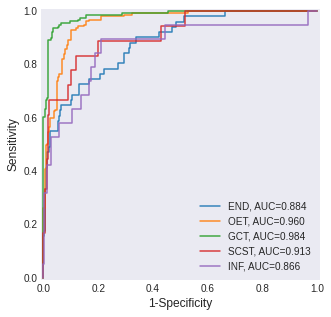

In [83]:
ys = metric["ys"] + 1
ys[ys==5]=0
probability = metric["probability"][:,[4,0,1,2,3]]
auc_plot(ys,torch.softmax(probability,dim=1),
#          name=['Other epithelial tumors','germ cell','sex cord-stromal','inflammation','endometrosis']
         name=['END','OET','GCT','SCST','INF']
        )

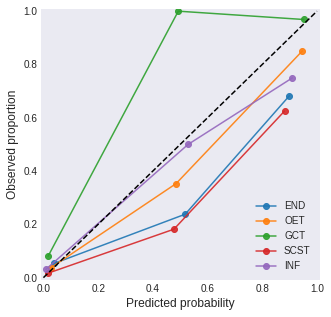

In [84]:
import sklearn
from sklearn import calibration
def calibration(y,p,name):
    bins = 3
    plt.figure(figsize=(5,5))
    for i in range(p.shape[1]):
        yy = y.clone()
        yy[yy==i]=10
        yy[yy!=10]=0
        yy[yy!=0]=1
        
        curve = sklearn.calibration.calibration_curve(yy,p[:,i],n_bins=bins,normalize=True)
        
        plt.plot(curve[1], curve[0],marker="o" , linewidth=1.5, alpha=0.9, 
                 label=name[i]) 
    plt.plot([0,1],[0,1],linestyle="--",c='black')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel("Predicted probability",fontsize=12)
    plt.ylabel("Observed proportion",fontsize=12)
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.savefig("./20220617/external2_pathology_calibration.png",dpi=600)
    
calibration(ys,torch.softmax(probability,dim=1),
#             name=['Other epithelial tumors','germ cell','sex cord-stromal','inflammation','endometrosis'],
         name=['END','OET','GCT','SCST','INF']
           )

(5, 5)


/tmp/ipykernel_3422/3124591612.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


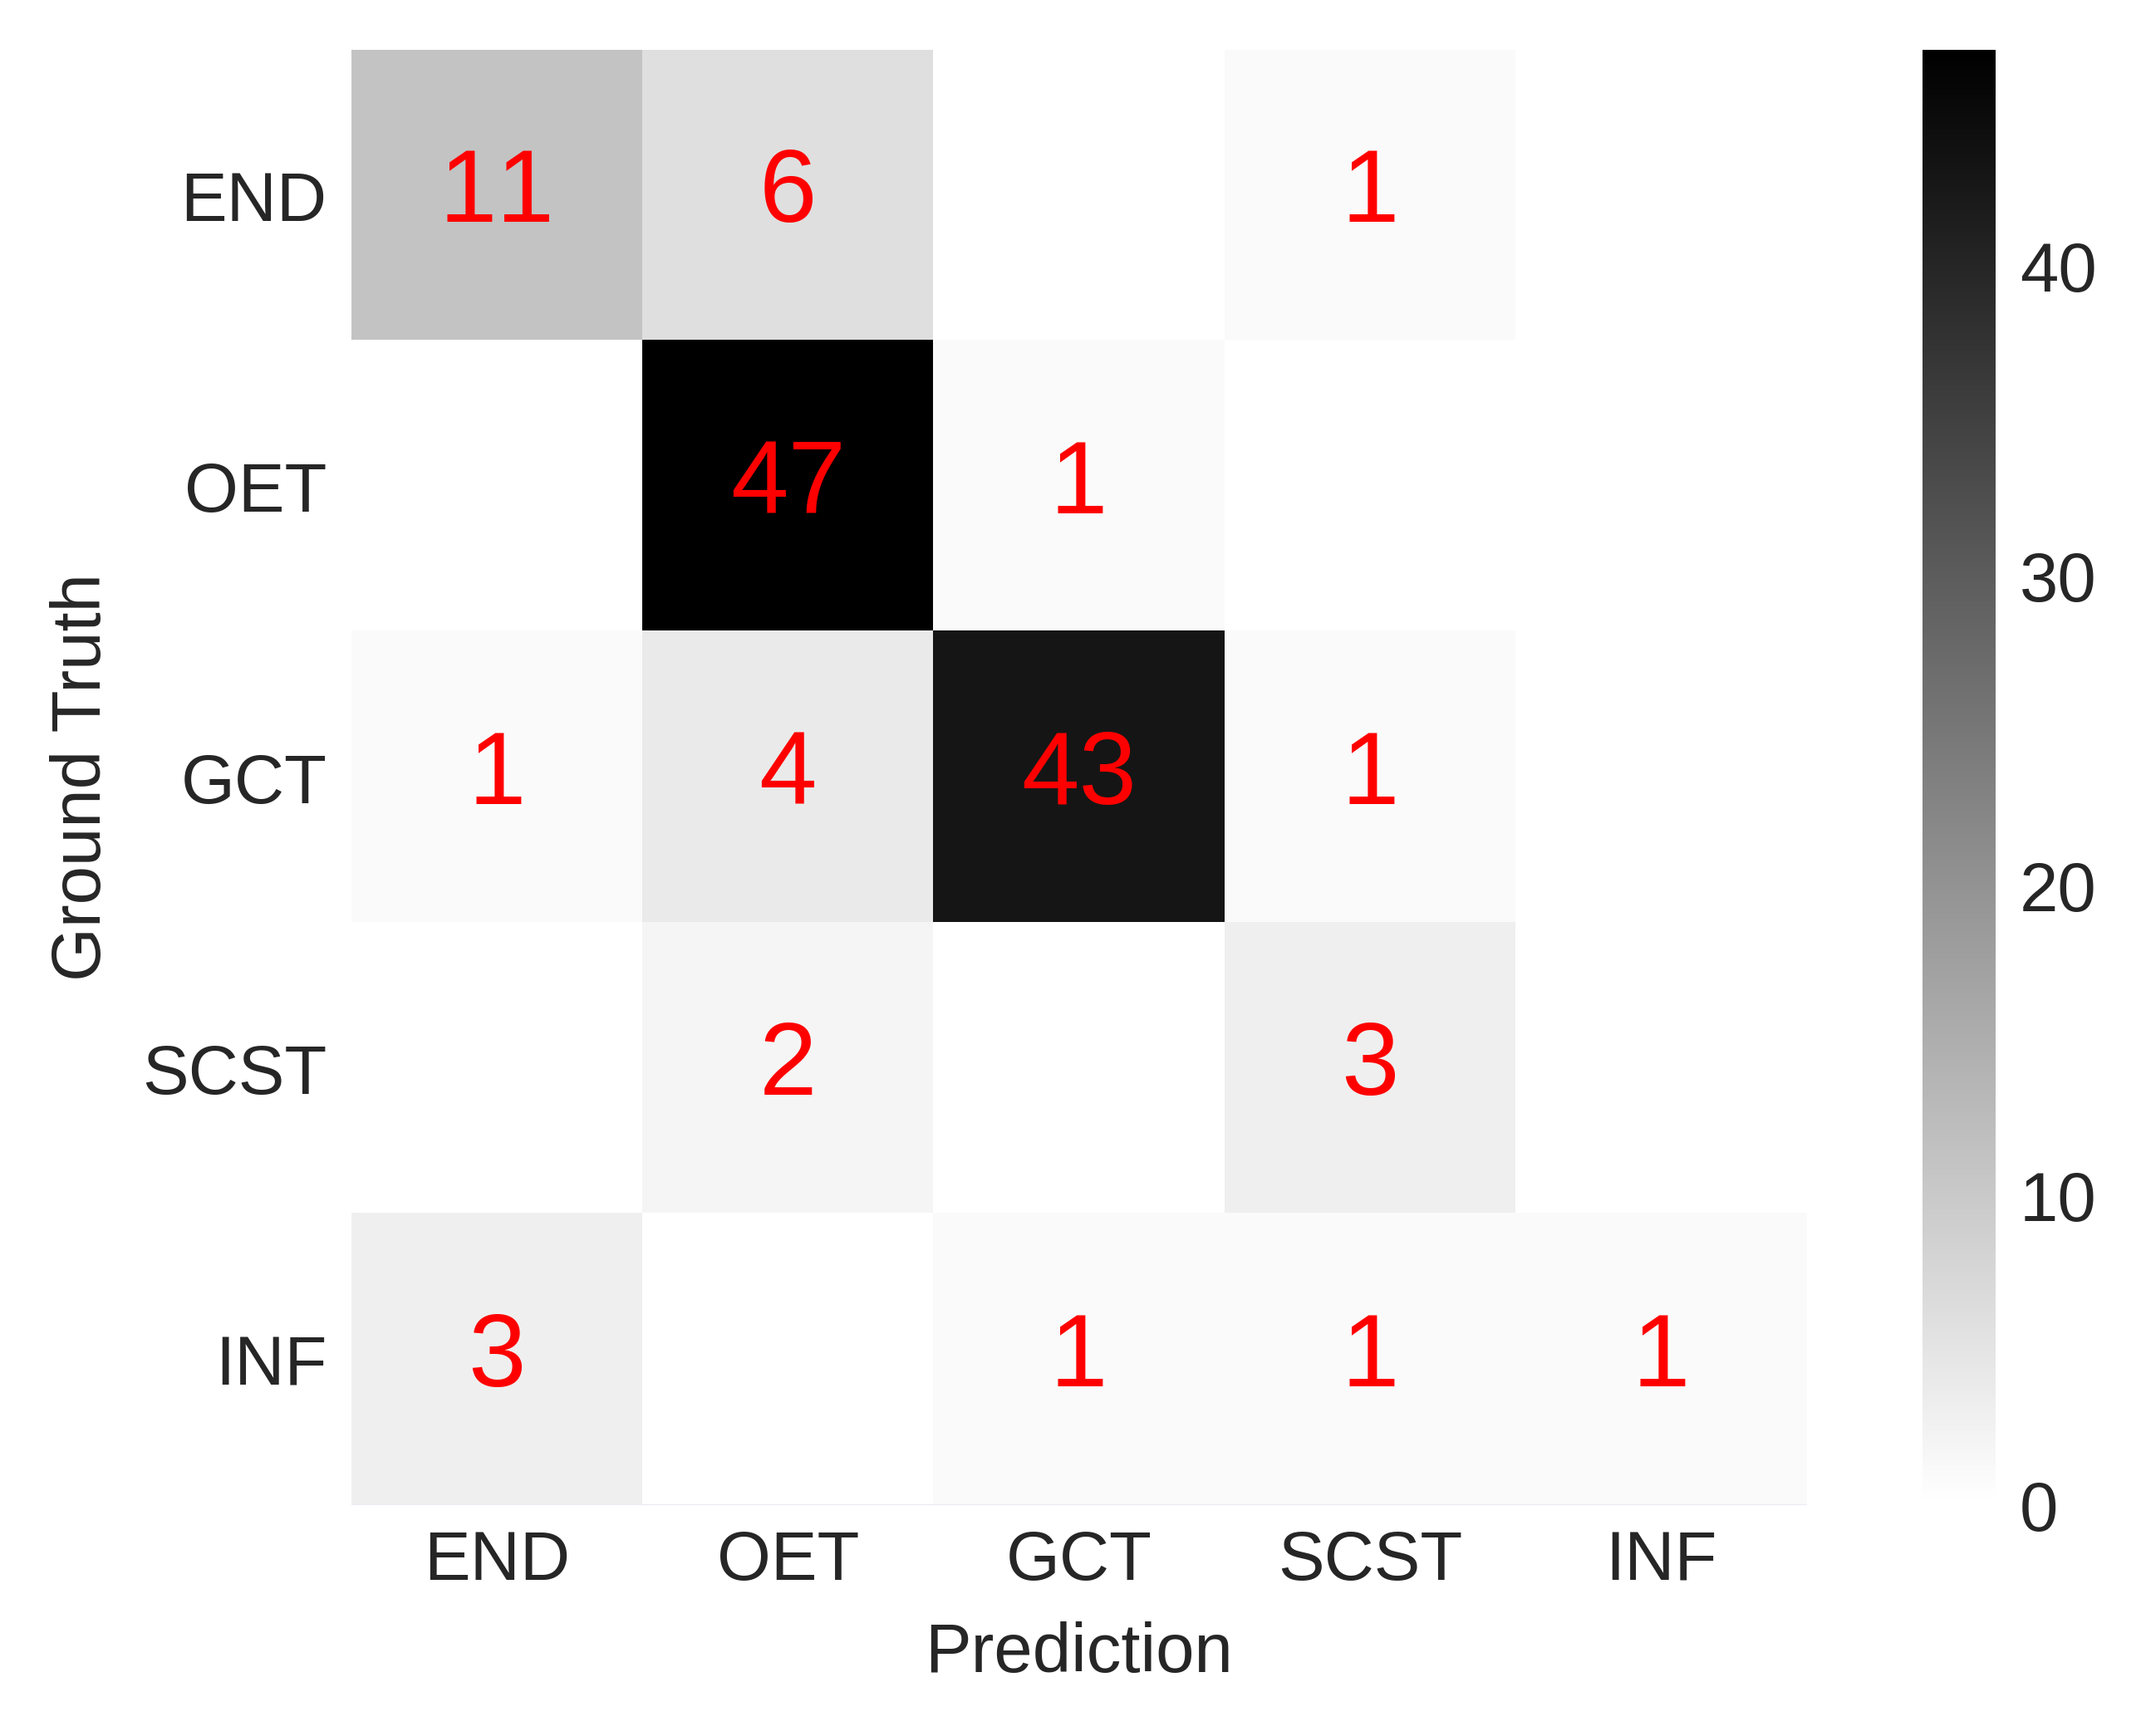

In [85]:

def plot_confusion_matrix(cm, savename, title='Confusion Matrix',classes=[]):

    plt.figure(figsize=(6, 4), dpi=600)
    np.set_printoptions(precision=2)

    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.0f" % (c,), color='red', fontsize=15, va='center', ha='center')
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=0)
    plt.yticks(xlocations, classes)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
#     plt.grid(False, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
    plt.grid(False)
    plt.savefig("./20220617/external2_pathology_confusion_matrix.png",dpi=600)
    plt.show()
pred,gt = cal_case_acc(metric["name"],metric["preds"],metric["ys"])
cm = metrics.confusion_matrix(gt, pred)
cm = np.array(cm)
cm = cm[[4,0,1,2,3]]
cm = cm[:,[4,0,1,2,3]]
print(cm.shape)
plot_confusion_matrix(cm, './20220530/pathology_confusion_matrix.png',
                      title='',
#                      classes=['Other epithelial tumors','germ cell','sex cord-stromal','inflammation','endometrosis']
         classes=['END','OET','GCT','SCST','INF']
                     
                     )

In [105]:
from tqdm import tqdm
def CI(y,p):
    for i in range(int(np.max(y) + 1)):
#         if i == 3:
#             continue
        yy = y.copy()
        yy[yy==i]=10
        yy[yy!=10]=0
        yy[yy!=0]=1
        
        accs = []
        sens = []
        spes = []
        aucs = []
        ppvs = []
        npvs = []
        f1s = []
        for ii in tqdm(range(1000)):
            rand_inx = np.random.choice(np.arange(len(yy)),int(len(yy) * 1),replace=False)
            
            pp = p[rand_inx]
            
            pp[pp==i]=10
            pp[pp!=10]=0
            pp[pp!=0]=1
            
            TP,TN,FP,FN = 0,0,0,0
            for yyy,ppp in zip(yy[rand_inx],pp):
                if yyy == ppp:
                    if ppp == 1:
                        TP += 1
                    else:
                        TN += 1
                else:
                    if ppp == 1:
                        FP += 1
                    else:
                        FN += 1
            try:
                accs.append((TP+TN) / (TP+TN+FP+FN))
                sens.append((TP) / (TP+FN))
                spes.append((TN) / (TN+FP))
    #             aucs.append(roc_auc1)
                ppvs.append((TP) / (TP + FP))
                npvs.append((TN) / (TN + FN))
                recall = (TP) / (TP +FN)
                precision = (TP) / (TP + FP)
                f1 = (2 * recall * precision) / (recall + precision)
                f1s.append(f1)
            except:
                continue
        print('-'*20)
        for n,name in zip([accs,sens,spes,ppvs,npvs,f1s],
                         ["acc","sens","spes","ppv","npv","f1s"]):
            print(name)
            print(sorted(n)[int(len(n) * 0.05)],sorted(n)[int(len(n) * 0.95)])
        
CI(gt,pred)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 9737.35it/s]


--------------------
acc
0.8627450980392157 0.8627450980392157
sens
0.875 0.875
spes
0.8571428571428571 0.8571428571428571
ppv
0.7368421052631579 0.7368421052631579
npv
0.9375 0.9375
f1s
0.7999999999999999 0.7999999999999999


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 9598.28it/s]


--------------------
acc
0.9215686274509803 0.9215686274509803
sens
0.8571428571428571 0.8571428571428571
spes
0.9459459459459459 0.9459459459459459
ppv
0.8571428571428571 0.8571428571428571
npv
0.9459459459459459 0.9459459459459459
f1s
0.8571428571428571 0.8571428571428571


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 10387.42it/s]


--------------------
acc
0.9607843137254902 0.9607843137254902
sens
0.8 0.8
spes
0.9782608695652174 0.9782608695652174
ppv
0.8 0.8
npv
0.9782608695652174 0.9782608695652174
f1s
0.8000000000000002 0.8000000000000002


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 9600.94it/s]


--------------------
acc
0.9803921568627451 0.9803921568627451
sens
0.6666666666666666 0.6666666666666666
spes
1.0 1.0
ppv
1.0 1.0
npv
0.9795918367346939 0.9795918367346939
f1s
0.8 0.8


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 9601.51it/s]

--------------------
acc
0.9215686274509803 0.9215686274509803
sens
0.7692307692307693 0.7692307692307693
spes
0.9736842105263158 0.9736842105263158
ppv
0.9090909090909091 0.9090909090909091
npv
0.925 0.925
f1s
0.8333333333333333 0.8333333333333333


In [106]:
def BS(y,pred):
    N = len(y)
    y = torch.nn.functional.one_hot(torch.tensor(y))
    bs = torch.sum(torch.mean((y-pred)**2,dim=1)) / N 
    return bs
    
BS(metric['ys'],torch.softmax(metric['probability'],dim=1))

/tmp/ipykernel_3422/739237614.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.nn.functional.one_hot(torch.tensor(y))


tensor(0.0641)